# Neuronal Functional Connectivity Estimation

In [4]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from scipy import linalg
import seaborn as sns
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

import globals as glb
import utils
import plot_utils
from data_loader import SpontaneousRecordingData, PartialSpontDataset
# from data_loader import PartialSpaceRecordingDataset, PartialTimeRecordingDataset, PartialLayerRecordingDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Dataset with Spontaneous Activities Only

In [5]:
# Recording without visual stimuli
spont_mat = scipy.io.loadmat(glb.DATA_DIR + "dbspont.mat").get("db")[0]  # 9 datasets of recordings

FileNotFoundError: [Errno 2] No such file or directory: './data/dbspont.mat'

In [3]:
# Session 1: Around 140 mins
SIDX = 0
spont0_fp = glb.DATA_DIR + "_".join(["spont", spont_mat[SIDX][glb.SESSION_NAME][0], spont_mat[0][glb.REC_DATE][0]])
spont_dataset0 = SpontaneousRecordingData(data_fp=spont0_fp)


NameError: name 'spont_mat' is not defined

In [4]:
# Basic statistics about the dataset
spont_dataset0.display_field_shapes()

neuron counts: 11983
layer counts: 9
Layer 0: 1131 neurons
Layer 1: 1183 neurons
Layer 2: 1218 neurons
Layer 3: 1321 neurons
Layer 4: 1415 neurons
Layer 5: 1471 neurons
Layer 6: 1418 neurons
Layer 7: 1440 neurons
Layer 8: 1386 neurons
timestamp counts 21054
running speed (21054, 1)
face motion mask (240, 320, 1000)
face motion svd (21054, 1000)
avg frame (240, 320)
pupil area (21054, 1)
pupil com (21054, 2)
eye motion svd (21054, 500)
whisker motion mask (216, 304, 500)
whisker motion SVD (21054, 500)


In [5]:
# Randomly selected neuron traces
spont_dataset0.display_aggregated_stats()

fsp:
- mean: [63.403896 50.399834 44.502342 ... 50.019924 59.62232  80.88147 ]
- std: [142.98846  116.771225 116.605606 ... 130.43459  152.64905  183.18759 ]
running speed:
-mean: 3.9668139108024194
- std: 9.045952631537109
- range: 0.00 ~ 60.30
pupil area:
- mean: 902.2317785988538
- std: 374.5450626253281
- range: 234.56 ~ 2550.95


{'fsp': {'mean': array([63.403896, 50.399834, 44.502342, ..., 50.019924, 59.62232 ,
         80.88147 ], dtype=float32),
  'std': array([142.98846 , 116.771225, 116.605606, ..., 130.43459 , 152.64905 ,
         183.18759 ], dtype=float32)},
 'run_speed': {'mean': 3.9668139108024194, 'std': 9.045952631537109},
 'pupil_area': {'mean': 902.2317785988538, 'std': 374.5450626253281}}

Pupil Area data NaN percentage:  0.0


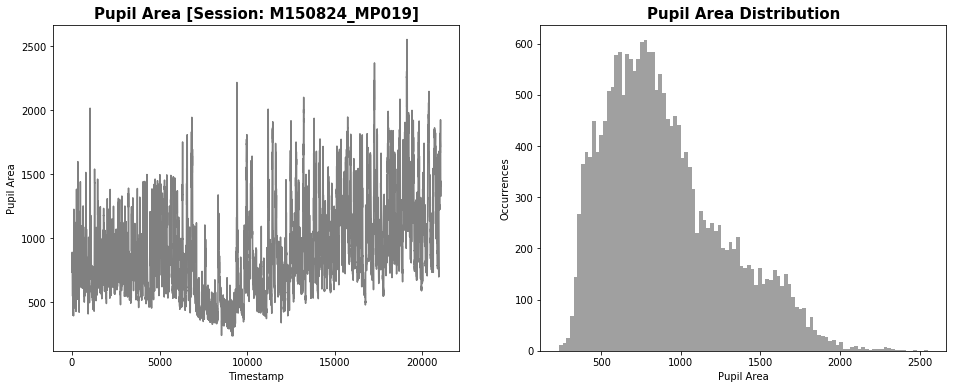

In [6]:
# Pupil Area
spont_dataset0.display_pupil_area()

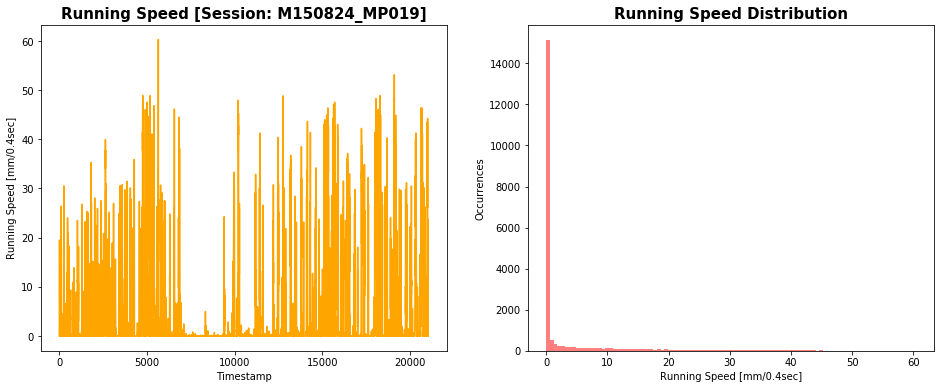

In [7]:
# Running speed time series
spont_dataset0.display_run_speed()

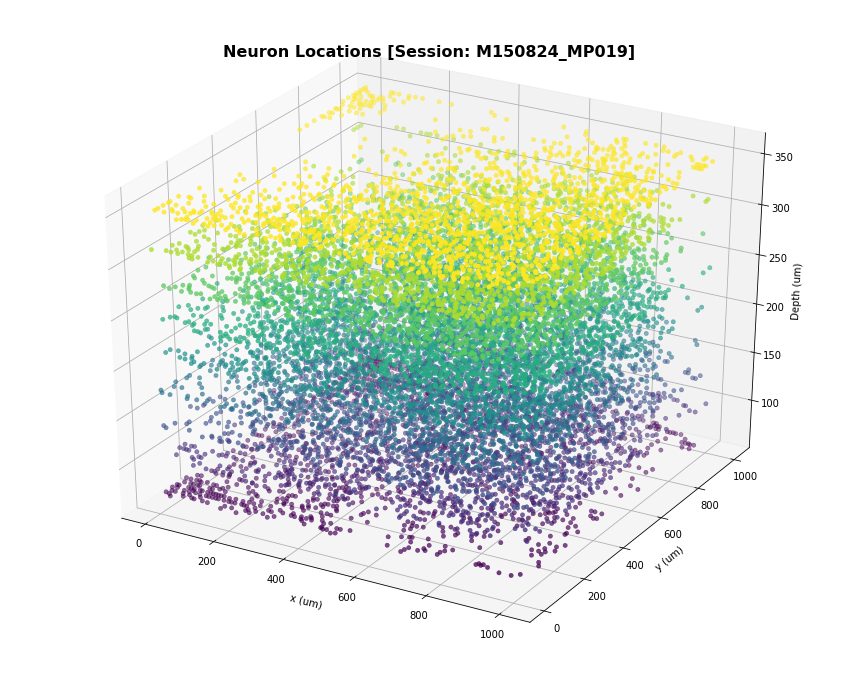

In [8]:
# Neuron locations
plt.figure(figsize=(15, 12))
spont_dataset0.display_neuron_3d(session_name="Spontaneous Session 0")  # Starting at 70, increment = 35

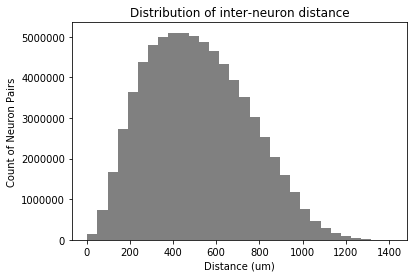

In [9]:
# Inter-neuron Distance Distribution
dist = spont_dataset0.inter_neuron_distance(plot=True)

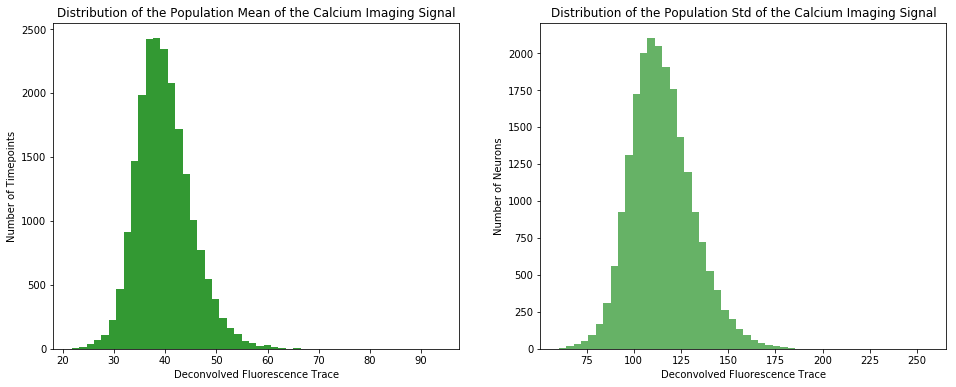

In [10]:
# Display Calcium Trace Mean and Std Distribution
spont_dataset0.display_fsp_distribution_all_time()

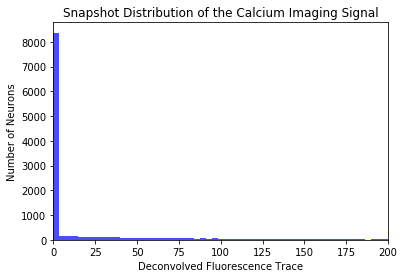

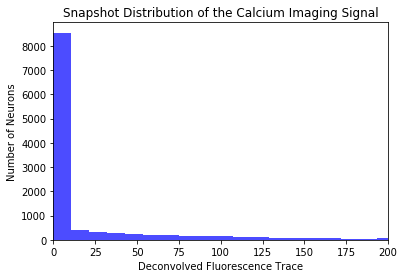

In [54]:
# Display Calcium Trace Distribution at a Specific Instant
spont_dataset0.display_fsp_distribution_instant(timepoint=1000, bins=500)  # This is the bad guy!!!!!

spont_dataset0.display_fsp_distribution_instant(timepoint=10, bins=150)

## Use a subset of neurons' recording from the full data above

In [91]:
# Truncate the fsp matrix
# NOTE: Every 180 timestamps for 5 minutes
start_tp = 900
end_tp = 1800
neuron_idxs = np.arange(100)
layer_idx = 0

In [92]:
# Take the top layer neuron
dataX = spont_dataset0.get_layer_fsp(layer=layer_idx)[neuron_idxs, start_tp:end_tp]

# Center dataX
mu = np.mean(dataX, axis=1)
dataX = np.transpose(np.transpose(dataX) - mu)

print(dataX.shape)  # n * T

(100, 900)


## Compute covariance matrix
- Sample covariance matrix
- RLA Sample covariance matrix

In [93]:
from sklearn.covariance import empirical_covariance
from RLA import RLA_cov

In [94]:
# sample cov
sample_cov = np.cov(dataX, bias=False)  # bias: divide by (N-1) since mean is not a priori, but an estimation 
print("Sample covariance matrix is PD: ", utils.check_PD(sample_cov))

# RLA sample cov
rla_cov_c = int(0.5 * (end_tp - start_tp))
rla_cov_uni = RLA_cov(dataX, c=rla_cov_c, sampler="uniform")
print("RLA-uniform Sample covariance matrix is PD: ", utils.check_PD(rla_cov_uni))

rla_cov_minvar = RLA_cov(dataX, c=rla_cov_c, sampler="minvar")
print("RLA-minvar Sample covariance matrix is PD: ", utils.check_PD(rla_cov_minvar))

Sample covariance matrix is PD:  True
RLA-uniform Sample covariance matrix is PD:  True
RLA-minvar Sample covariance matrix is PD:  True


## Fit Graphical Lasso
The first 3 cells below are based on the fully python version of the Enet coordinate descent, which is really really slow!!
#### DON'T RUN the following 3 cells, unless dataX is within (100, 100)!

In [29]:
from Glasso_sklearn import graphical_lasso
# regularization strength
alpha = 0.1

In [33]:
# sample cov
glasso_cov, glasso_prec = graphical_lasso(sample_cov, alpha=alpha)

# RLA sample cov (uniform)
glasso_rla_uni_cov, glasso_rla_uni_prec = graphical_lasso(rla_cov_uni, alpha=alpha)

# RLA sample cov (minvar)
glasso_rla_minvar_cov, glasso_rla_minvar_prec = graphical_lasso(rla_cov_minvar, alpha=alpha)


KeyboardInterrupt: 

## Fit Graphical Lasso

In [95]:
from sklearn.covariance import graphical_lasso
alpha = 0.001

In [96]:
# sample cov
start = time.time()
glasso_cov, glasso_prec = graphical_lasso(sample_cov, alpha=alpha)
runtime = int(time.time() - start)
print("Glasso finished in %d seconds for FULL sample covariance" % runtime)


Glasso finished in 0 seconds for FULL sample covariance


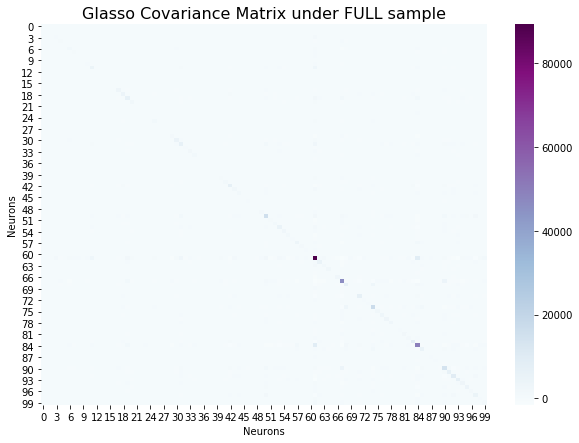

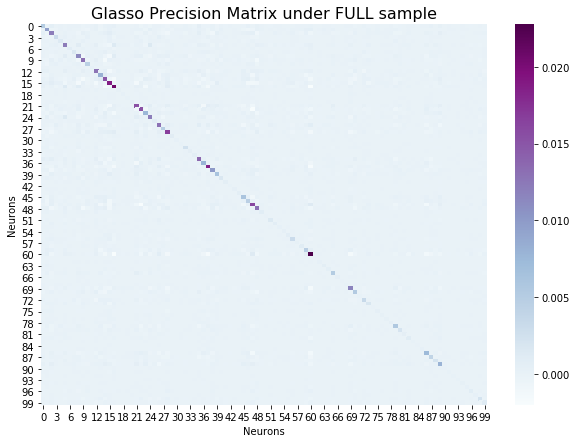

In [97]:
plot_utils.plot_matrix(glasso_cov, title="Glasso Covariance Matrix under FULL sample")

plot_utils.plot_matrix(glasso_prec, title="Glasso Precision Matrix under FULL sample")

In [98]:
# RLA sample cov (uniform)
start = time.time()
glasso_rla_uni_cov, glasso_rla_uni_prec = graphical_lasso(rla_cov_uni, alpha=alpha)
runtime = int(time.time() - start)
print("Glasso finished in %d seconds for RLA-UNI sample covariance" % runtime)

Glasso finished in 0 seconds for RLA-UNI sample covariance


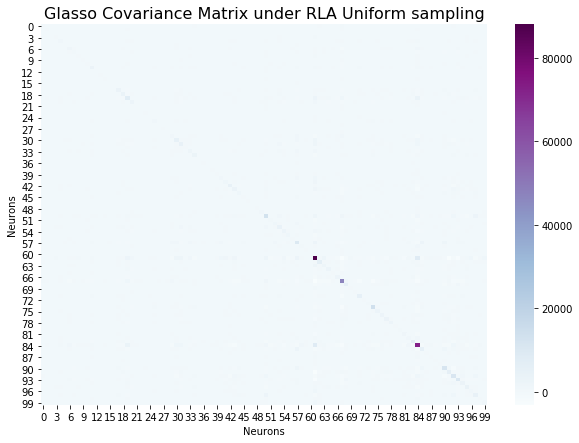

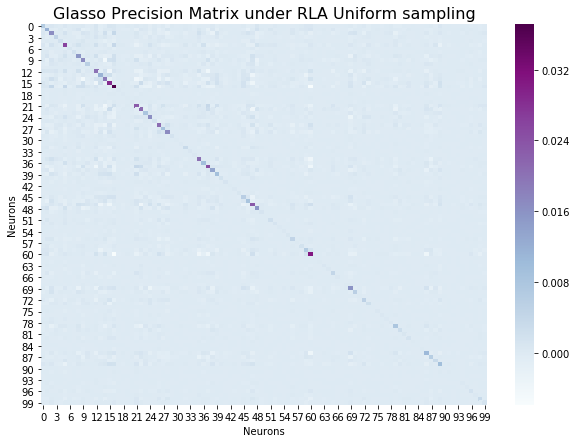

In [99]:
plot_utils.plot_matrix(glasso_rla_uni_cov, title="Glasso Covariance Matrix under RLA Uniform sampling")

plot_utils.plot_matrix(glasso_rla_uni_prec, title="Glasso Precision Matrix under RLA Uniform sampling")

In [100]:
# RLA sample cov (minvar)
start = time.time()
glasso_rla_minvar_cov, glasso_rla_minvar_prec = graphical_lasso(rla_cov_minvar, alpha=alpha)
runtime = int(time.time() - start)
print("Glasso finished in %d seconds for RLA-MINVAR sample covariance" % runtime)

Glasso finished in 0 seconds for RLA-MINVAR sample covariance


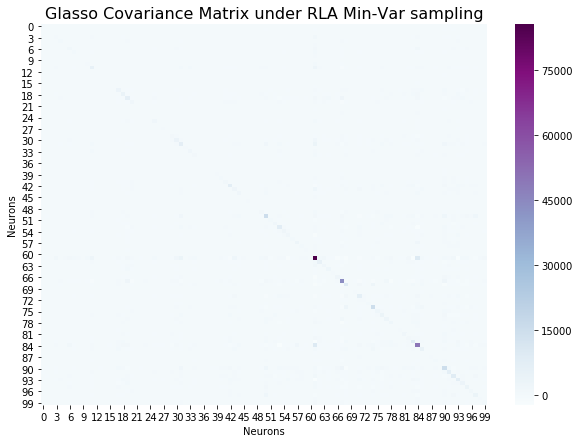

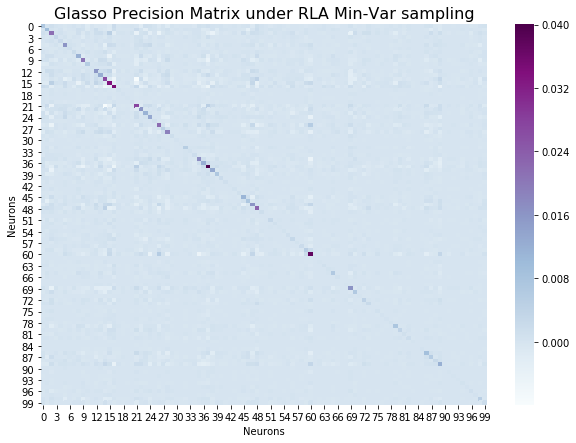

In [101]:
plot_utils.plot_matrix(glasso_rla_minvar_cov, title="Glasso Covariance Matrix under RLA Min-Var sampling")

plot_utils.plot_matrix(glasso_rla_minvar_prec, title="Glasso Precision Matrix under RLA Min-Var sampling")

# Topology construction (Plot connectivity graph)

## FDR Control
It may be challenging to evaluate the Glasso-generated graph from the real data, but simulated data can provide a fairly robust ground truth graph to evaluate.